In [1]:
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import skimage.transform
from IPython.display import Image, display

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
gpus = tf.config.list_physical_devices("GPU") 
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs
Metal device set to: Apple M1 Pro


2022-12-15 16:07:09.134502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-15 16:07:09.134614: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
import os
from ple.games.flappybird import FlappyBird
from ple import PLE

os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

test_game = FlappyBird()
test_env = PLE(test_game, fps=30, display_screen=False)
test_env.reset_game()

couldn't import doomish
Couldn't import doom


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [4]:
path = './movie_f' 
if not os.path.exists(path):
    os.makedirs(path)

In [5]:
hparas = {
    'image_size': 84,
    'num_stack': 4,
    'action_dim': len(env.getActionSet()),
    'hidden_size': 256,
    'lr': 0.0001,
    'gamma': 0.99,
    'lambda': 0.95,
    'clip_val': 0.2,
    'ppo_epochs': 8,
    'test_epochs': 1,
    'num_steps': 512,
    'mini_batch_size': 64,
    'target_reward': 200,
    'max_episode': 30000,
}

In [6]:
# Please do not modify this method
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    
    return clip

In [7]:
def preprocess_screen(screen):
    screen = skimage.transform.rotate(screen, -90, resize=True)
    screen = screen[:400, :]
    screen = skimage.transform.resize(screen, [hparas['image_size'], hparas['image_size'], 1])
    return screen.astype(np.float32)

def frames_to_state(input_frames):
    if(len(input_frames) == 1):
        state = np.concatenate(input_frames*4, axis=-1)
    elif(len(input_frames) == 2):
        state = np.concatenate(input_frames[0:1]*2 + input_frames[1:]*2, axis=-1)
    elif(len(input_frames) == 3):
        state = np.concatenate(input_frames + input_frames[2:], axis=-1)
    else:
        state = np.concatenate(input_frames[-4:], axis=-1)

    return state

In [8]:
class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, hparas):
        super().__init__()

        self.feature_extractor = tf.keras.Sequential([
          # Convolutional Layers
          tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1),
          tf.keras.layers.ReLU(),
          # Embedding Layers
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(hparas['hidden_size']),
          tf.keras.layers.ReLU(),
        ])

        # Actor Network
        self.actor = tf.keras.layers.Dense(hparas['action_dim'], activation='softmax')
        # Critic Network
        self.critic = tf.keras.layers.Dense(1, activation = None)

    def call(self, input):
        x = self.feature_extractor(input)
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value

In [9]:
class Agent():
    def __init__(self, hparas):
        self.gamma = hparas['gamma']
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=hparas['lr'])
        self.actor_critic = ActorCriticNetwork(hparas)
        self.clip_pram = hparas['clip_val']
    
    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.shape[0]
        for _ in range(batch_size // mini_batch_size):
            rand_ids = tf.convert_to_tensor(np.random.randint(0, batch_size, mini_batch_size), dtype=tf.int32)
            yield tf.gather(states, rand_ids), tf.gather(actions, rand_ids), tf.gather(log_probs, rand_ids), \
             tf.gather(returns, rand_ids), tf.gather(advantage, rand_ids)
    
    def ppo_update(self, ppo_epochs, mini_batch_size, states, actions, log_probs, discount_rewards, advantages):       
        total_actor_loss = 0
        total_critic_loss = 0
        for _ in range(ppo_epochs):
            for state, action, old_log_probs, reward, advantage in self.ppo_iter(mini_batch_size, states, actions, log_probs, discount_rewards, advantages):
                reward = tf.expand_dims(reward, axis=-1)

                with tf.GradientTape() as tape:
                    prob, value = self.actor_critic(state, training=True)
                    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
                    entropy = tf.math.reduce_mean(dist.entropy())
                    new_log_probs = dist.log_prob(action)

                    # PPO ratio
                    ratio = tf.math.exp(new_log_probs - old_log_probs)
                    surr1 = ratio * advantage
                    surr2 = tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram) * advantage

                    actor_loss = tf.math.negative(tf.math.reduce_mean(tf.math.minimum(surr1, surr2))) - 0.1 * entropy
                    critic_loss = 0.5 * tf.math.reduce_mean(kls.mean_squared_error(reward, value))

                    total_loss = actor_loss + critic_loss
            
                # single optimizer
                grads = tape.gradient(total_loss, self.actor_critic.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.actor_critic.trainable_variables))
      
                total_actor_loss += actor_loss
                total_critic_loss += critic_loss
        return total_actor_loss, total_critic_loss

In [10]:
# https://arxiv.org/pdf/1506.02438.pdf
# Equation 16
def compute_gae(rewards, masks, values, gamma, LAMBDA):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        gae = delta + gamma * LAMBDA * masks[i] * gae
        returns.append(gae + values[i])

    returns.reverse()
    return returns

In [11]:
def test_reward(test_env, agent):
    total_reward = 0
    # Reset the environment
    test_env.reset_game()
    input_frames = [preprocess_screen(test_env.getScreenGrayscale())]

    while not test_env.game_over():

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        action = np.argmax(prob[0].numpy())
        reward = test_env.act(test_env.getActionSet()[action])
        total_reward += reward

        input_frames.append(preprocess_screen(test_env.getScreenGrayscale()))

    return total_reward

In [12]:
agent = Agent(hparas)
max_episode = hparas['max_episode']
test_per_n_episode = 10
force_save_per_n_episode = 1000
early_stop_reward = 10

start_s = 0
best_reward = -5.0

checkpoint = tf.train.Checkpoint(
    actor_critic = agent.actor_critic,
    optimizer = agent.optimizer,
)

# Load from old checkpoint
# checkpoint.restore('ckpt_dir/ckpt-?')

In [13]:
ep_reward = []
total_avgr = []
early_stop = False
avg_rewards_list = []

env.reset_game()

for s in range(0, max_episode):
    if early_stop == True:
        break

    rewards = []
    states = []
    actions = []
    log_probs = []
    masks = []
    values = []

    display_frames = [env.getScreenRGB()]
    input_frames = [preprocess_screen(env.getScreenGrayscale())]

    for step in range(hparas['num_steps']):

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        dist = tfp.distributions.Categorical(probs=prob[0], dtype=tf.float32)
        action = dist.sample(1)
        log_prob = dist.log_prob(action)

        reward = env.act(env.getActionSet()[int(action.numpy())])

        done = env.game_over()

        states.append(state)
        actions.append(action)
        values.append(value[0])
        log_probs.append(log_prob)
        rewards.append(tf.convert_to_tensor(reward, dtype=tf.float32))
        masks.append(tf.convert_to_tensor(1-int(done), dtype=tf.float32))

        display_frames.append(env.getScreenRGB())
        input_frames.append(preprocess_screen(env.getScreenGrayscale()))

        if done:
            env.reset_game()
            input_frames = [preprocess_screen(env.getScreenGrayscale())]
  
    _, next_value = agent.actor_critic(state)
    values.append(next_value[0])

    returns = compute_gae(rewards, masks, values, hparas['gamma'], hparas['lambda'])

    returns = tf.concat(returns, axis=0)
    log_probs = tf.concat(log_probs, axis=0)
    values = tf.concat(values, axis=0)
    states = tf.concat(states, axis=0)
    actions = tf.concat(actions, axis=0)
    advantage = returns - values[:-1]

    a_loss, c_loss = agent.ppo_update(hparas['ppo_epochs'], hparas['mini_batch_size'], states, actions, log_probs, returns, advantage)
    print('[Episode %d]  Actor loss: %.5f, Critic loss: %.5f' % (s, a_loss, c_loss))

    if s % test_per_n_episode == 0:
        # test agent hparas['test_epochs'] times to get the average reward
        avg_reward = np.mean([test_reward(test_env, agent) for _ in range(hparas['test_epochs'])])
        print("Test average reward is %.1f, Current best average reward is %.1f\n" % (avg_reward, best_reward))
        avg_rewards_list.append(avg_reward)

        if avg_reward > best_reward:
            best_reward = avg_reward
            agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
            checkpoint.save(file_prefix = './save/checkpoints/ckpt')

    if s % force_save_per_n_episode == 0:
        agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        checkpoint.save(file_prefix = './save/checkpoints/ckpt')
        clip = make_anim(display_frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie_f/{}_demo-{}.webm".format('Lab15', s), fps=60)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, maxduration=120))

    if best_reward >= early_stop_reward:
        early_stop = True

[Episode 0]  Actor loss: 83.58367, Critic loss: 57.29298
Test average reward is -5.0, Current best average reward is -5.0



2022-12-15 16:22:07.166365: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-5.0/assets
Moviepy - Building video movie_f/Lab15_demo-0.webm.
Moviepy - Writing video movie_f/Lab15_demo-0.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-0.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1]  Actor loss: 52.24748, Critic loss: 31.90302
[Episode 2]  Actor loss: 27.34282, Critic loss: 18.74116
[Episode 3]  Actor loss: 15.76524, Critic loss: 7.74320
[Episode 4]  Actor loss: 18.03428, Critic loss: 9.07187
[Episode 5]  Actor loss: 8.25338, Critic loss: 7.51298
[Episode 6]  Actor loss: -1.90504, Critic loss: 3.40574
[Episode 7]  Actor loss: 2.51744, Critic loss: 4.31421
[Episode 8]  Actor loss: -0.79123, Critic loss: 3.35708
[Episode 9]  Actor loss: -0.19431, Critic loss: 2.81615
[Episode 10]  Actor loss: -1.33153, Critic loss: 2.40391
Test average reward is -4.0, Current best average reward is -5.0

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_10_-4.0/assets
[Episode 11]  Actor loss: -2.50496, Critic loss: 2.33195
[Episode 12]  Actor loss: -1.21918, Critic loss: 1.60476
[Episode 13]  Actor loss: -3.37583, Critic loss: 1.74985
[Episode 14]  Actor loss: -5.55023, Critic loss: 1.40322
[Episode 15]  Actor loss: -5.97022, Critic loss: 1.51775
[Episode 16] 

[Episode 130]  Actor loss: -5.42338, Critic loss: 0.39389
Test average reward is -5.0, Current best average reward is -4.0

[Episode 131]  Actor loss: -5.42012, Critic loss: 0.43581
[Episode 132]  Actor loss: -11.69169, Critic loss: 2.23620
[Episode 133]  Actor loss: -5.95260, Critic loss: 0.47649
[Episode 134]  Actor loss: -6.25419, Critic loss: 0.47479
[Episode 135]  Actor loss: -5.10642, Critic loss: 0.64427
[Episode 136]  Actor loss: -3.10363, Critic loss: 0.27440
[Episode 137]  Actor loss: -2.09116, Critic loss: 0.56599
[Episode 138]  Actor loss: -6.98741, Critic loss: 0.33467
[Episode 139]  Actor loss: -3.98091, Critic loss: 0.50494
[Episode 140]  Actor loss: 0.45920, Critic loss: 0.51772
Test average reward is -5.0, Current best average reward is -4.0

[Episode 141]  Actor loss: -7.38600, Critic loss: 0.32658
[Episode 142]  Actor loss: -3.83102, Critic loss: 0.47026
[Episode 143]  Actor loss: -6.20896, Critic loss: 0.28509
[Episode 144]  Actor loss: -9.12974, Critic loss: 0.2895

[Episode 257]  Actor loss: -9.20352, Critic loss: 0.88869
[Episode 258]  Actor loss: -5.13941, Critic loss: 0.46167
[Episode 259]  Actor loss: -1.54424, Critic loss: 0.40047
[Episode 260]  Actor loss: -7.34728, Critic loss: 0.28941
Test average reward is -5.0, Current best average reward is -4.0

[Episode 261]  Actor loss: -2.83680, Critic loss: 0.25430
[Episode 262]  Actor loss: -7.44822, Critic loss: 0.18606
[Episode 263]  Actor loss: -6.80590, Critic loss: 0.29638
[Episode 264]  Actor loss: -7.19750, Critic loss: 0.32291
[Episode 265]  Actor loss: -7.92689, Critic loss: 0.32884
[Episode 266]  Actor loss: -3.39342, Critic loss: 0.25176
[Episode 267]  Actor loss: -3.47089, Critic loss: 0.30136
[Episode 268]  Actor loss: -4.23786, Critic loss: 0.41119
[Episode 269]  Actor loss: -2.29199, Critic loss: 0.32699
[Episode 270]  Actor loss: -4.37675, Critic loss: 0.33650
Test average reward is -5.0, Current best average reward is -4.0

[Episode 271]  Actor loss: -3.79302, Critic loss: 0.4853

[Episode 384]  Actor loss: -4.39125, Critic loss: 0.35650
[Episode 385]  Actor loss: -5.23864, Critic loss: 0.35223
[Episode 386]  Actor loss: -5.45343, Critic loss: 0.31719
[Episode 387]  Actor loss: -4.38369, Critic loss: 0.38171
[Episode 388]  Actor loss: -3.07954, Critic loss: 0.30673
[Episode 389]  Actor loss: -1.13978, Critic loss: 0.47486
[Episode 390]  Actor loss: -2.97024, Critic loss: 0.29754
Test average reward is -5.0, Current best average reward is -4.0

[Episode 391]  Actor loss: -6.32298, Critic loss: 0.34853
[Episode 392]  Actor loss: -2.85116, Critic loss: 0.37373
[Episode 393]  Actor loss: -6.01271, Critic loss: 0.38596
[Episode 394]  Actor loss: -6.15082, Critic loss: 0.30674
[Episode 395]  Actor loss: -0.62438, Critic loss: 0.41597
[Episode 396]  Actor loss: -5.50999, Critic loss: 0.60594
[Episode 397]  Actor loss: -2.67211, Critic loss: 0.38851
[Episode 398]  Actor loss: -7.65624, Critic loss: 0.29365
[Episode 399]  Actor loss: -6.05703, Critic loss: 0.65478
[Episo

[Episode 511]  Actor loss: -2.53624, Critic loss: 0.79741
[Episode 512]  Actor loss: -1.81312, Critic loss: 0.49144
[Episode 513]  Actor loss: -3.19184, Critic loss: 0.28667
[Episode 514]  Actor loss: -0.56309, Critic loss: 0.27604
[Episode 515]  Actor loss: -1.76560, Critic loss: 0.27376
[Episode 516]  Actor loss: -10.21167, Critic loss: 0.77525
[Episode 517]  Actor loss: -6.45068, Critic loss: 0.71554
[Episode 518]  Actor loss: -3.92080, Critic loss: 0.50403
[Episode 519]  Actor loss: -4.45012, Critic loss: 0.30905
[Episode 520]  Actor loss: -1.70570, Critic loss: 0.43782
Test average reward is -5.0, Current best average reward is -4.0

[Episode 521]  Actor loss: -1.57193, Critic loss: 0.39689
[Episode 522]  Actor loss: -10.61387, Critic loss: 1.41324
[Episode 523]  Actor loss: -1.69592, Critic loss: 0.56919
[Episode 524]  Actor loss: -4.96738, Critic loss: 0.23515
[Episode 525]  Actor loss: -3.12278, Critic loss: 0.27340
[Episode 526]  Actor loss: -5.28232, Critic loss: 0.24857
[Epi

[Episode 639]  Actor loss: -10.46204, Critic loss: 0.72306
[Episode 640]  Actor loss: -2.98495, Critic loss: 0.43819
Test average reward is -5.0, Current best average reward is -4.0

[Episode 641]  Actor loss: -5.55895, Critic loss: 0.65373
[Episode 642]  Actor loss: 0.09720, Critic loss: 0.41781
[Episode 643]  Actor loss: -12.31631, Critic loss: 1.27448
[Episode 644]  Actor loss: -2.94369, Critic loss: 1.17466
[Episode 645]  Actor loss: -6.94865, Critic loss: 1.10970
[Episode 646]  Actor loss: -0.78282, Critic loss: 0.87102
[Episode 647]  Actor loss: -6.34959, Critic loss: 0.56968
[Episode 648]  Actor loss: -10.18741, Critic loss: 0.90083
[Episode 649]  Actor loss: 1.99591, Critic loss: 1.20610
[Episode 650]  Actor loss: -4.09718, Critic loss: 0.98276
Test average reward is -5.0, Current best average reward is -4.0

[Episode 651]  Actor loss: 0.33774, Critic loss: 0.47094
[Episode 652]  Actor loss: -6.07372, Critic loss: 1.06705
[Episode 653]  Actor loss: -1.48911, Critic loss: 0.3575

[Episode 766]  Actor loss: -9.35112, Critic loss: 0.78318
[Episode 767]  Actor loss: -5.13204, Critic loss: 0.66094
[Episode 768]  Actor loss: -2.40943, Critic loss: 0.92052
[Episode 769]  Actor loss: -2.79439, Critic loss: 0.86480
[Episode 770]  Actor loss: -6.50994, Critic loss: 0.80893
Test average reward is -5.0, Current best average reward is -4.0

[Episode 771]  Actor loss: -7.19476, Critic loss: 1.20983
[Episode 772]  Actor loss: -2.48816, Critic loss: 1.33794
[Episode 773]  Actor loss: -6.89420, Critic loss: 1.09116
[Episode 774]  Actor loss: -7.01996, Critic loss: 0.76614
[Episode 775]  Actor loss: 0.27438, Critic loss: 0.86731
[Episode 776]  Actor loss: -0.96700, Critic loss: 0.39359
[Episode 777]  Actor loss: -0.05954, Critic loss: 0.66998
[Episode 778]  Actor loss: -11.10462, Critic loss: 0.82621
[Episode 779]  Actor loss: -13.55995, Critic loss: 3.16943
[Episode 780]  Actor loss: -9.49753, Critic loss: 1.72862
Test average reward is -5.0, Current best average reward is -4.

[Episode 893]  Actor loss: -12.31839, Critic loss: 1.57193
[Episode 894]  Actor loss: -2.96042, Critic loss: 0.76506
[Episode 895]  Actor loss: -2.86050, Critic loss: 1.69034
[Episode 896]  Actor loss: -9.02879, Critic loss: 1.05507
[Episode 897]  Actor loss: -1.73163, Critic loss: 0.75723
[Episode 898]  Actor loss: -10.17539, Critic loss: 1.69794
[Episode 899]  Actor loss: -2.13288, Critic loss: 1.43608
[Episode 900]  Actor loss: 3.40471, Critic loss: 1.10744
Test average reward is -5.0, Current best average reward is -4.0

[Episode 901]  Actor loss: -11.78368, Critic loss: 1.64295
[Episode 902]  Actor loss: -4.12747, Critic loss: 0.83208
[Episode 903]  Actor loss: 1.46324, Critic loss: 0.65347
[Episode 904]  Actor loss: -1.65694, Critic loss: 0.40173
[Episode 905]  Actor loss: -5.66764, Critic loss: 0.44775
[Episode 906]  Actor loss: -7.88668, Critic loss: 1.03512
[Episode 907]  Actor loss: -5.89968, Critic loss: 0.47716
[Episode 908]  Actor loss: -1.39982, Critic loss: 0.88784
[Epis

Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-1000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1001]  Actor loss: -3.48534, Critic loss: 1.95777
[Episode 1002]  Actor loss: -7.41816, Critic loss: 0.92387
[Episode 1003]  Actor loss: -1.71253, Critic loss: 1.09398
[Episode 1004]  Actor loss: -7.85450, Critic loss: 5.15572
[Episode 1005]  Actor loss: -8.73500, Critic loss: 1.35468
[Episode 1006]  Actor loss: -7.91501, Critic loss: 1.15252
[Episode 1007]  Actor loss: -6.81650, Critic loss: 3.21656
[Episode 1008]  Actor loss: 2.00828, Critic loss: 2.21973
[Episode 1009]  Actor loss: -7.37551, Critic loss: 2.23486
[Episode 1010]  Actor loss: -3.24672, Critic loss: 1.76751
Test average reward is -5.0, Current best average reward is -4.0

[Episode 1011]  Actor loss: 3.41507, Critic loss: 1.27228
[Episode 1012]  Actor loss: -4.17728, Critic loss: 1.93273
[Episode 1013]  Actor loss: -17.05535, Critic loss: 1.88410
[Episode 1014]  Actor loss: -14.86147, Critic loss: 2.45475
[Episode 1015]  Actor loss: -13.56106, Critic loss: 3.73905
[Episode 1016]  Actor loss: -20.75426, Critic lo

[Episode 1127]  Actor loss: -13.92804, Critic loss: 1.00797
[Episode 1128]  Actor loss: -15.77861, Critic loss: 1.49573
[Episode 1129]  Actor loss: -14.00310, Critic loss: 2.17164
[Episode 1130]  Actor loss: -10.07080, Critic loss: 5.33801
Test average reward is -5.0, Current best average reward is -4.0

[Episode 1131]  Actor loss: -12.61193, Critic loss: 5.06165
[Episode 1132]  Actor loss: 5.63364, Critic loss: 4.65754
[Episode 1133]  Actor loss: 9.86895, Critic loss: 2.93172
[Episode 1134]  Actor loss: 10.41989, Critic loss: 2.92660
[Episode 1135]  Actor loss: 0.66223, Critic loss: 1.61089
[Episode 1136]  Actor loss: 6.72683, Critic loss: 1.81105
[Episode 1137]  Actor loss: 6.20917, Critic loss: 0.92213
[Episode 1138]  Actor loss: -5.78011, Critic loss: 2.11658
[Episode 1139]  Actor loss: -7.43602, Critic loss: 1.45284
[Episode 1140]  Actor loss: -6.12765, Critic loss: 2.78488
Test average reward is -5.0, Current best average reward is -4.0

[Episode 1141]  Actor loss: -11.71352, Cri

Test average reward is -4.0, Current best average reward is -2.0

[Episode 1251]  Actor loss: -28.49817, Critic loss: 3.16185
[Episode 1252]  Actor loss: -9.92332, Critic loss: 3.70438
[Episode 1253]  Actor loss: 4.89741, Critic loss: 2.11828
[Episode 1254]  Actor loss: -5.47014, Critic loss: 2.19325
[Episode 1255]  Actor loss: -8.50237, Critic loss: 5.82805
[Episode 1256]  Actor loss: 8.45950, Critic loss: 1.86829
[Episode 1257]  Actor loss: -10.38450, Critic loss: 3.25485
[Episode 1258]  Actor loss: -1.69320, Critic loss: 1.74623
[Episode 1259]  Actor loss: 4.19118, Critic loss: 1.97010
[Episode 1260]  Actor loss: 3.92667, Critic loss: 1.12232
Test average reward is -5.0, Current best average reward is -2.0

[Episode 1261]  Actor loss: -6.54094, Critic loss: 1.55609
[Episode 1262]  Actor loss: -10.21628, Critic loss: 2.23830
[Episode 1263]  Actor loss: -18.17566, Critic loss: 3.83564
[Episode 1264]  Actor loss: -16.00008, Critic loss: 2.36944
[Episode 1265]  Actor loss: -9.43327, Cri

[Episode 1376]  Actor loss: -20.67728, Critic loss: 1.83123
[Episode 1377]  Actor loss: -17.01924, Critic loss: 2.47307
[Episode 1378]  Actor loss: -5.57814, Critic loss: 3.33490
[Episode 1379]  Actor loss: 0.00307, Critic loss: 1.12787
[Episode 1380]  Actor loss: -13.55679, Critic loss: 1.29989
Test average reward is -5.0, Current best average reward is -2.0

[Episode 1381]  Actor loss: -17.83384, Critic loss: 1.57491
[Episode 1382]  Actor loss: -3.73995, Critic loss: 1.38861
[Episode 1383]  Actor loss: -3.30833, Critic loss: 1.30712
[Episode 1384]  Actor loss: -8.56962, Critic loss: 2.23348
[Episode 1385]  Actor loss: -10.00583, Critic loss: 2.88631
[Episode 1386]  Actor loss: -0.95195, Critic loss: 1.04903
[Episode 1387]  Actor loss: 0.09132, Critic loss: 1.04587
[Episode 1388]  Actor loss: -14.15978, Critic loss: 3.48234
[Episode 1389]  Actor loss: -5.76402, Critic loss: 2.22815
[Episode 1390]  Actor loss: -9.20535, Critic loss: 2.81507
Test average reward is -5.0, Current best ave

[Episode 1501]  Actor loss: 3.75206, Critic loss: 2.47567
[Episode 1502]  Actor loss: 7.74567, Critic loss: 4.33920
[Episode 1503]  Actor loss: -7.13442, Critic loss: 2.22123
[Episode 1504]  Actor loss: -7.65845, Critic loss: 3.00877
[Episode 1505]  Actor loss: -13.20076, Critic loss: 5.85521
[Episode 1506]  Actor loss: -10.64385, Critic loss: 3.12058
[Episode 1507]  Actor loss: -21.54063, Critic loss: 2.87550
[Episode 1508]  Actor loss: -19.17318, Critic loss: 4.71956
[Episode 1509]  Actor loss: -14.27132, Critic loss: 3.30127
[Episode 1510]  Actor loss: -25.92226, Critic loss: 3.52288
Test average reward is -5.0, Current best average reward is -2.0

[Episode 1511]  Actor loss: -12.83098, Critic loss: 2.38036
[Episode 1512]  Actor loss: -1.85227, Critic loss: 5.22189
[Episode 1513]  Actor loss: -16.69451, Critic loss: 3.63885
[Episode 1514]  Actor loss: -29.52095, Critic loss: 2.64273
[Episode 1515]  Actor loss: -3.03541, Critic loss: 5.28854
[Episode 1516]  Actor loss: -6.71244, Crit

[Episode 1626]  Actor loss: -2.54374, Critic loss: 3.71340
[Episode 1627]  Actor loss: -13.91244, Critic loss: 3.67136
[Episode 1628]  Actor loss: -18.57901, Critic loss: 3.12473
[Episode 1629]  Actor loss: -18.54668, Critic loss: 2.96920
[Episode 1630]  Actor loss: -10.07860, Critic loss: 4.79364
Test average reward is -4.0, Current best average reward is -2.0

[Episode 1631]  Actor loss: -4.69520, Critic loss: 5.13877
[Episode 1632]  Actor loss: 2.01967, Critic loss: 5.39403
[Episode 1633]  Actor loss: 6.43097, Critic loss: 4.03430
[Episode 1634]  Actor loss: 10.66372, Critic loss: 3.91653
[Episode 1635]  Actor loss: -12.68675, Critic loss: 3.28727
[Episode 1636]  Actor loss: -24.70683, Critic loss: 3.29137
[Episode 1637]  Actor loss: 0.60255, Critic loss: 2.63659
[Episode 1638]  Actor loss: -20.62169, Critic loss: 4.19294
[Episode 1639]  Actor loss: -38.22686, Critic loss: 5.17412
[Episode 1640]  Actor loss: -4.70810, Critic loss: 6.32826
Test average reward is -5.0, Current best av

[Episode 1750]  Actor loss: -33.60842, Critic loss: 4.45802
Test average reward is -5.0, Current best average reward is 2.0

[Episode 1751]  Actor loss: -15.02451, Critic loss: 8.15508
[Episode 1752]  Actor loss: -0.78976, Critic loss: 2.94965
[Episode 1753]  Actor loss: -18.72762, Critic loss: 5.90437
[Episode 1754]  Actor loss: 15.11338, Critic loss: 2.58752
[Episode 1755]  Actor loss: -3.28393, Critic loss: 2.90946
[Episode 1756]  Actor loss: -14.35640, Critic loss: 3.65085
[Episode 1757]  Actor loss: -22.83341, Critic loss: 4.06913
[Episode 1758]  Actor loss: -14.03361, Critic loss: 3.26144
[Episode 1759]  Actor loss: -23.35939, Critic loss: 2.28029
[Episode 1760]  Actor loss: -16.57612, Critic loss: 2.52929
Test average reward is -2.0, Current best average reward is 2.0

[Episode 1761]  Actor loss: -6.16819, Critic loss: 3.00219
[Episode 1762]  Actor loss: 4.57034, Critic loss: 2.58150
[Episode 1763]  Actor loss: -3.74752, Critic loss: 3.43865
[Episode 1764]  Actor loss: -24.52285

[Episode 1874]  Actor loss: -15.01106, Critic loss: 7.17939
[Episode 1875]  Actor loss: -37.87164, Critic loss: 5.50151
[Episode 1876]  Actor loss: -22.57809, Critic loss: 4.55500
[Episode 1877]  Actor loss: -5.07137, Critic loss: 5.97916
[Episode 1878]  Actor loss: 2.04753, Critic loss: 6.65237
[Episode 1879]  Actor loss: -7.24388, Critic loss: 6.57601
[Episode 1880]  Actor loss: -1.88890, Critic loss: 8.38547
Test average reward is 2.0, Current best average reward is 2.0

[Episode 1881]  Actor loss: -26.81265, Critic loss: 4.74847
[Episode 1882]  Actor loss: -30.44998, Critic loss: 3.66918
[Episode 1883]  Actor loss: -8.44833, Critic loss: 6.16939
[Episode 1884]  Actor loss: -9.58382, Critic loss: 5.68571
[Episode 1885]  Actor loss: -19.66970, Critic loss: 12.37255
[Episode 1886]  Actor loss: 13.32943, Critic loss: 13.63737
[Episode 1887]  Actor loss: -1.13599, Critic loss: 8.87311
[Episode 1888]  Actor loss: 10.03982, Critic loss: 5.80093
[Episode 1889]  Actor loss: 1.08732, Critic 

[Episode 1997]  Actor loss: -9.30204, Critic loss: 6.03362
[Episode 1998]  Actor loss: -8.06416, Critic loss: 4.32803
[Episode 1999]  Actor loss: -0.88934, Critic loss: 10.57700
[Episode 2000]  Actor loss: -18.35150, Critic loss: 4.61745
Test average reward is -5.0, Current best average reward is 8.0

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2000_-5.0/assets
Moviepy - Building video movie_f/Lab15_demo-2000.webm.
Moviepy - Writing video movie_f/Lab15_demo-2000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-2000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 2001]  Actor loss: -14.32528, Critic loss: 5.54761
[Episode 2002]  Actor loss: -13.89450, Critic loss: 3.43959
[Episode 2003]  Actor loss: 3.32960, Critic loss: 9.79331
[Episode 2004]  Actor loss: -16.91654, Critic loss: 6.42494
[Episode 2005]  Actor loss: -3.83571, Critic loss: 6.40116
[Episode 2006]  Actor loss: -36.24307, Critic loss: 4.19234
[Episode 2007]  Actor loss: 9.34307, Critic loss: 7.99117
[Episode 2008]  Actor loss: -5.12832, Critic loss: 6.78339
[Episode 2009]  Actor loss: -19.32631, Critic loss: 5.87262
[Episode 2010]  Actor loss: -21.79625, Critic loss: 10.14090
Test average reward is -3.0, Current best average reward is 8.0

[Episode 2011]  Actor loss: -20.82804, Critic loss: 7.87349
[Episode 2012]  Actor loss: 2.70115, Critic loss: 3.14455
[Episode 2013]  Actor loss: -1.63301, Critic loss: 6.04923
[Episode 2014]  Actor loss: -5.67958, Critic loss: 10.40480
[Episode 2015]  Actor loss: -24.08411, Critic loss: 3.40496
[Episode 2016]  Actor loss: -9.09330, Criti

[Episode 2127]  Actor loss: -8.77649, Critic loss: 4.26521
[Episode 2128]  Actor loss: 6.92361, Critic loss: 4.09828
[Episode 2129]  Actor loss: 10.86120, Critic loss: 4.16736
[Episode 2130]  Actor loss: -6.99288, Critic loss: 4.80288
Test average reward is 1.0, Current best average reward is 8.0

[Episode 2131]  Actor loss: -8.47645, Critic loss: 8.93297
[Episode 2132]  Actor loss: 1.55823, Critic loss: 4.86877
[Episode 2133]  Actor loss: -4.21653, Critic loss: 2.61563
[Episode 2134]  Actor loss: -6.75488, Critic loss: 2.00369
[Episode 2135]  Actor loss: -16.00245, Critic loss: 2.95548
[Episode 2136]  Actor loss: -12.30058, Critic loss: 3.68592
[Episode 2137]  Actor loss: -20.22019, Critic loss: 3.02166
[Episode 2138]  Actor loss: -37.69350, Critic loss: 3.40869
[Episode 2139]  Actor loss: -36.65870, Critic loss: 3.83332
[Episode 2140]  Actor loss: -29.09864, Critic loss: 3.12175
Test average reward is -5.0, Current best average reward is 8.0

[Episode 2141]  Actor loss: -29.43617, Cr

[Episode 2251]  Actor loss: -37.48735, Critic loss: 6.04352
[Episode 2252]  Actor loss: -14.28118, Critic loss: 5.22657
[Episode 2253]  Actor loss: -20.03644, Critic loss: 6.98676
[Episode 2254]  Actor loss: -25.73116, Critic loss: 5.89024
[Episode 2255]  Actor loss: -35.71707, Critic loss: 6.12956
[Episode 2256]  Actor loss: -19.26675, Critic loss: 4.68208
[Episode 2257]  Actor loss: -27.58342, Critic loss: 4.00846
[Episode 2258]  Actor loss: -24.47017, Critic loss: 5.21500
[Episode 2259]  Actor loss: -14.93624, Critic loss: 5.73655
[Episode 2260]  Actor loss: -21.56742, Critic loss: 6.93605
Test average reward is 4.0, Current best average reward is 8.0

[Episode 2261]  Actor loss: -1.34433, Critic loss: 8.37027
[Episode 2262]  Actor loss: -28.61076, Critic loss: 7.57483
[Episode 2263]  Actor loss: 1.57975, Critic loss: 4.32962
[Episode 2264]  Actor loss: 7.41966, Critic loss: 13.63568
[Episode 2265]  Actor loss: 22.77776, Critic loss: 12.99355
[Episode 2266]  Actor loss: -1.84838, Cr

[Episode 2376]  Actor loss: -2.02608, Critic loss: 3.64327
[Episode 2377]  Actor loss: 1.60482, Critic loss: 2.42075
[Episode 2378]  Actor loss: -14.61170, Critic loss: 4.82399
[Episode 2379]  Actor loss: -9.17409, Critic loss: 4.79993
[Episode 2380]  Actor loss: -23.31945, Critic loss: 5.35226
Test average reward is -4.0, Current best average reward is 8.0

[Episode 2381]  Actor loss: -12.35436, Critic loss: 4.47489
[Episode 2382]  Actor loss: -33.75876, Critic loss: 5.66136
[Episode 2383]  Actor loss: 3.58696, Critic loss: 7.10375
[Episode 2384]  Actor loss: -3.49841, Critic loss: 6.09784
[Episode 2385]  Actor loss: -27.82195, Critic loss: 6.47911
[Episode 2386]  Actor loss: -22.27143, Critic loss: 7.22967
[Episode 2387]  Actor loss: -1.82123, Critic loss: 12.64888
[Episode 2388]  Actor loss: -2.62818, Critic loss: 11.97050
[Episode 2389]  Actor loss: -18.13447, Critic loss: 8.41698
[Episode 2390]  Actor loss: -10.41810, Critic loss: 8.90074
Test average reward is 1.0, Current best a

Test average reward is -5.0, Current best average reward is 8.0

[Episode 2501]  Actor loss: -1.03317, Critic loss: 4.70265
[Episode 2502]  Actor loss: 17.02725, Critic loss: 9.43235
[Episode 2503]  Actor loss: -11.40884, Critic loss: 6.53684
[Episode 2504]  Actor loss: -28.64787, Critic loss: 6.08789
[Episode 2505]  Actor loss: -6.17612, Critic loss: 4.53366
[Episode 2506]  Actor loss: -13.10097, Critic loss: 8.53024
[Episode 2507]  Actor loss: -21.06189, Critic loss: 4.31883
[Episode 2508]  Actor loss: 6.48334, Critic loss: 9.13518
[Episode 2509]  Actor loss: -42.05195, Critic loss: 4.20936
[Episode 2510]  Actor loss: -8.99533, Critic loss: 9.34011
Test average reward is -5.0, Current best average reward is 8.0

[Episode 2511]  Actor loss: -44.76495, Critic loss: 2.98627
[Episode 2512]  Actor loss: -12.83213, Critic loss: 6.60834
[Episode 2513]  Actor loss: -8.95095, Critic loss: 7.07545
[Episode 2514]  Actor loss: -11.64076, Critic loss: 7.40019
[Episode 2515]  Actor loss: -15.71198

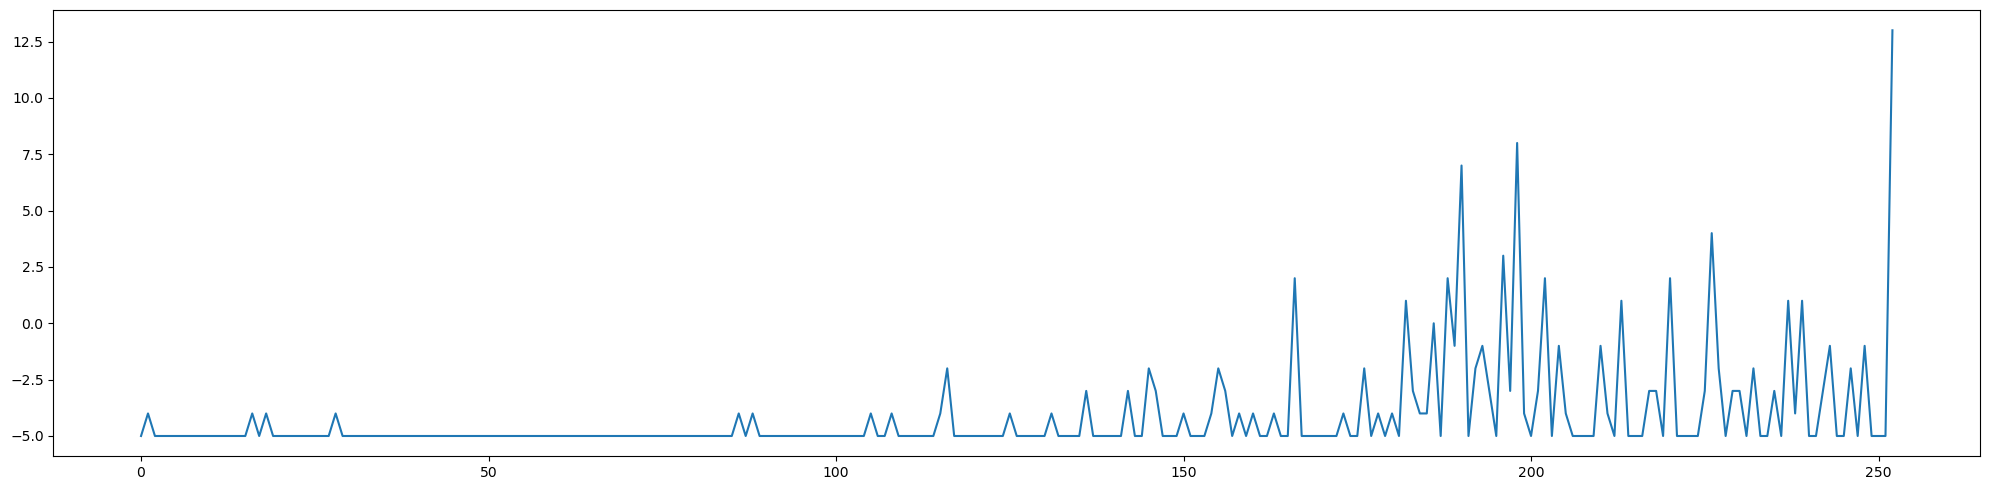

In [14]:
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(avg_rewards_list)), avg_rewards_list)
fig.tight_layout()
plt.show()

Compared to using Q-Learning and SARSA (reinforcement learning), we can clearly see that the result of using PPO x GAE (deep reinforcement learning) is much bettter. Eventhough it took a lot longer than only using the rl but the significant improve in reward is worth the time. Moreover, another advantage of using PPO x GAE is that it can automatically stop itself when it reached a certain average reward value hence it can actually be faster then using reinforcement learning. And also by using PPO x GAE, it is more scallable since that if we use Q-Learning and SARSA on a bigger environment, it might take very long time for it to finish running.

And when we see the graph above, we can see that our agent can achieve an average reward value of more than 10 in just around 200 epoch which is significantly better than using reinforcement learning only.